# From expectation maximization to stochastic variational inference

This is a guide to variational auto-encoders.

## Introduction

Given a probabilistic model $p(\mathbf{x};\boldsymbol\theta)$ and some observations $\mathbf{x}$, we often want to estimate optimal parameter values $\boldsymbol{\hat{\theta}}$ that maximize the data likelihood. This can be done via [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (ML) estimation or [maximum a posteriori](https://de.wikipedia.org/wiki/Maximum_a_posteriori) (MAP) estimation if point estimates of $\boldsymbol\theta$ are sufficient:

$$
\boldsymbol{\hat{\theta}} = \underset{\boldsymbol\theta}{\mathrm{argmax}}\ p(\mathbf{x};\boldsymbol\theta)\tag{1}
$$

In many cases, direct computation and optimization of the likelihood function $p(\mathbf{x};\boldsymbol\theta)$ is complex or impossible. One option to ease computation is the introduction of [latent variables](https://en.wikipedia.org/wiki/Latent_variable) $\mathbf{t}$ so that we have a complete data likelihood $p(\mathbf{x},\mathbf{t};\boldsymbol\theta)$ which can be decomposed into a conditional likelihood $p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)$ and a prior $p(\mathbf{t})$.

$$
p(\mathbf{x},\mathbf{t};\boldsymbol\theta) = p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)p(\mathbf{t})\tag{2}
$$

Latent variables are not observed directly but assumed to cause observations $\mathbf{x}$. Their choice is problem-dependent. To obtain the the marginal likelihood $p(\mathbf{x};\boldsymbol\theta)$, we have to integrate i.e. marginalize out the latent variables.

$$
p(\mathbf{x};\boldsymbol\theta) = 
\int p(\mathbf{x},\mathbf{t};\boldsymbol\theta)d\mathbf{t} = 
\int p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)p(\mathbf{t})d\mathbf{t}
\tag{3}
$$

Usually, we choose a latent variable model such that parameter estimation for the conditional likelihood $p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)$ is easier than for the marginal likelihood $p(\mathbf{x};\boldsymbol\theta)$. For example, the conditional likelihood of a Gaussian [mixture model](https://en.wikipedia.org/wiki/Mixture_model) (GMM) is a single Gaussian for which parameter estimation is easier than for the marginal likelihood which is a mixture of Gaussians. The latent variable $\mathbf{t}$ in a GMM determines the soft-assignment to mixture components and follows a categorical distribution. If we can solve the integral in Eq. 3 we can also compute the posterior distribution of the latent variables by using [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$
p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta) = 
\frac{p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)p(\mathbf{t})}
    {p(\mathbf{x};\boldsymbol\theta)}
\tag{4}
$$

With the posterior, inference for the latent variables becomes possible. Note that in this article the term *estimation* is used to refer to (point) estimation of parameters via ML or MAP and *inference* to refer to Bayesian inference of random variables by computing the posterior. 

A major challenge in Bayesian inference is that the integral in Eq. 3 is often impossible or very difficult to compute in closed form. Therefore, many techniques exist to approximate the posterior in Eq. 4. They can be classified into numerical approximations ([Monte Carlo techniques](https://en.wikipedia.org/wiki/Monte_Carlo_method)) and deterministic approximations. This article is about deterministic approximations only, and their stochastic variants.

## Expectation maximization (EM)

Basis for many inference methods is the [expectation-maximization](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) (EM) algorithm. It is an iterative algorithm for estimating the parameters of latent variable models, often with closed-form updates at each step. We start with a rather general view of the EM algorithm that also serves as a basis for discussing variational inference methods later. It is straightforward to show<sup>[2]</sup> that the marginal log likelihood can be written as 

$$
\log p(\mathbf{x};\boldsymbol\theta) = 
  \mathcal{L}(q, \boldsymbol\theta) + 
  \mathrm{KL}(q \mid\mid p)
\tag{5}
$$

with 

$$
\mathcal{L}(q, \boldsymbol\theta) = \int q(\mathbf{t}) \log 
  \frac{p(\mathbf{x},\mathbf{t};\boldsymbol\theta)}
       {q(\mathbf{t})} d\mathbf{t}
\tag{6}
$$

and 

$$
\mathrm{KL}(q \mid\mid p) = - \int q(\mathbf{t}) \log 
  \frac{p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)}
       {q(\mathbf{t})} d\mathbf{t}
\tag{7}
$$

where $q(\mathbf{t})$ is any probability density function. $\mathrm{KL}(q \mid\mid p)$ is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between $q(\mathbf{t})$ and $p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)$ that measures how much $q$ diverges from $p$. The Kullback-Leibler divergence is zero for identical distributions and greater than zero otherwise. Thus, $\mathcal{L}(q, \boldsymbol\theta)$ is a lower bound of the log likelihood. It is equal to the log likelihood if $q(\mathbf{t}) = p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)$. In the E-step of the EM algorithm, $q(\mathbf{t})$ is therefore set to $p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)$ using the parameter values of the previous iteration $l-1$. 

$$
q^{l}(\mathbf{t}) = p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta^{l-1})\tag{8}
$$

Note that this requires that $p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)$ is known, like in the GMM case where the posterior is a categorical distribution, as mentioned above. In the M-step, $\mathcal{L}(q, \boldsymbol\theta)$ is optimized w.r.t. $\boldsymbol\theta$ using $q(\mathbf{t})$ from the E-step:

$$
\boldsymbol\theta^{l} = \underset{\boldsymbol\theta}{\mathrm{argmax}}\ \mathcal{L}(q^{l}, \boldsymbol\theta)\tag{9}
$$

In general, this is much simpler than optimizing $p(\mathbf{x};\boldsymbol\theta)$ directly. E and M steps are repeated until convergence. However, the requirement that the posterior $p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)$ must be known is rather restrictive and there are many cases where the posterior is intractable. In these cases, further approximations must be made.

## Variational EM

If the posterior is unknown, we have to assume specific forms of $q(\mathbf{t})$ and maximize the lower bound $\mathcal{L}(q, \boldsymbol\theta)$ w.r.t. these functions. The area of mathematics related to these optimization problems is called [calculus of variations](https://en.wikipedia.org/wiki/Calculus_of_variations)<sup>[3]</sup>, hence the name *variational EM*, or *variationial inference* in general. A widely used approximation for the unknown posterior is the [mean-field approximation](https://en.wikipedia.org/wiki/Mean_field_theory)<sup>[2][3]</sup> which factorizes $q(\mathbf{t})$ into $M$ partitions:

$$
q(\mathbf{t}) = \prod_{i=1}^{M} q_i(\mathbf{t}_i)\tag{10}
$$

For example, if $\mathbf{t}$ is 10-dimensional, we can factorize $q(\mathbf{t})$ into a product of 10 $q_i(\mathbf{t}_i)$, one for each dimension, assuming independence between dimensions. The approximate posterior $q(\mathbf{t})$ can be obtained by minimizing $\mathrm{KL}(q \mid\mid \tilde{p})$ which is the KL divergence between the factorized distribution $q(\mathbf{t})$ and the *unnormalized* posterior $\tilde{p}(\mathbf{t};\boldsymbol\theta) = p(\mathbf{x},\mathbf{t};\boldsymbol\theta)$. This leads to the following update formula for $q_i(\mathbf{t}_i)$:

$$
q_i^l(\mathbf{t}_i) = \mathbb{E}_{-q_i} \left[ \log\tilde{p}(\mathbf{t};\boldsymbol\theta^{l-1}) \right] + \mathrm{const} \tag{11}
$$

where $\mathbb{E}_{-q_i}$ denotes the expectation with respect to all variables of $\mathbf{t}$ except $t_i$. $\boldsymbol\theta^{l-1}$ are the parameters from the previous iteration. This is repeated for all $q_i$ until convergence. The E-step of the variational EM algorithm is therefore

$$
q^l(\mathbf{t}) = \prod_{i=1}^{M} q_i^l(\mathbf{t}_i)\tag{12}
$$

and the M-step uses the posterior approximation $q^l(\mathbf{t})$ from the E-step to estimate parameters $\boldsymbol\theta^l$:

$$
\boldsymbol\theta^{l} = \underset{\boldsymbol\theta}{\mathrm{argmax}}\ \mathcal{L}(q^{l}, \boldsymbol\theta)\tag{13}
$$

The mean field approach allows inference for many interesting latent variable models but it requires analytical solutions for the approximate posterior which is not always possible. Especially when used in context of deep learning where the approximate posterior $q(\mathbf{t})$ and the conditional likelihood $p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)$ are neural networks with at least one non-linear hidden layer, the mean field approach is not applicable any more<sup>[4]</sup>. Further approximations are required.

## Stochastic variational inference

Let's assume we have a latent variable model with one latent variable $\mathbf{t}^{(i)}$ for each observation $\mathbf{x}^{(i)}$. Observations $\mathbf{x}^{(i)}$ come from an i.i.d. dataset. To make the following more concrete let's say that $\mathbf{x}^{(i)}$ are images and $\mathbf{t}^{(i)}$ are $D$-dimensional latent vectors that cause the generation of $\mathbf{x}^{(i)}$ under the generative model $p(\mathbf{x},\mathbf{t};\boldsymbol\theta) = p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)p(\mathbf{t})$.

Our goal is to find optimal parameter values for the marginal likelihood $p(\mathbf{x};\boldsymbol\theta)$ by maximizing its variational lower bound. Here, we neither know the true posterior $p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)$ nor can we apply the mean field approximation<sup>[4]</sup>, so we have to make further approximations. We start by assuming that $q(\mathbf{t})$ is a factorized Gaussian i.e. a Gaussian with a diagonal covariance matrix and that we have a separate distribution $q^{(i)}$ for each latent variable $\mathbf{t}^{(i)}$: 

$$
q^{(i)}(\mathbf{t}^{(i)}) = 
  \mathcal{N}(\mathbf{t}^{(i)} \lvert \mathbf{m}^{(i)},\mathrm{diag}(\mathbf{s}^{2(i)}))
\tag{14}
$$

The problem here is that we have to estimate too many parameters. For example, if the latent space is 50-dimensional we have to estimate about 100 parameters per training object! This is not what we want. Another option is that all $q^{(i)}$ share their parameters $\mathbf{m}$ and $\mathbf{s}^2$ i.e. all $q^{(i)}$ are identical. This would keep the number of parameters constant but would be too restrictive though. If we want to support different $q^{(i)}$ for different $\mathbf{t}^{(i)}$ but with a limited number of parameters we should consider using parameters for $q$ that are functions of $\mathbf{x}^{(i)}$. These functions are themselves parametric functions that share a set of parameters $\boldsymbol\phi$:

$$
q^{(i)}(\mathbf{t}^{(i)}) = \mathcal{N}(\mathbf{t}^{(i)} \lvert 
  m(\mathbf{x}^{(i)},\boldsymbol\phi), \mathrm{diag}(s^2(\mathbf{x}^{(i)},\boldsymbol\phi)))
\tag{15}
$$

So we finally have a variational distribution $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ with a fixed number of parameters $\boldsymbol\phi$ as approximation for the true but unknown posterior $p(\mathbf{t} \lvert \mathbf{x};\boldsymbol\theta)$. To implement the (complex) functions $m$ and $s$ that map from an input image to the mean and the variance of that distribution we can use a [convolutional neural network](https://de.wikipedia.org/wiki/Convolutional_Neural_Network) (CNN) that is parameterized by $\boldsymbol\phi$. Similarly, for implementing $p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)$ we can use another neural network, parameterized by $\boldsymbol\theta$, that maps a latent vector $\mathbf{t}$ to the sufficient statistics of that probability distribution. Since $\mathbf{t}$ is often a lower-dimensional embedding or code of image $\mathbf{x}$, $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ is referred to as *probabilistic encoder* and $p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)$ as *probabilistic decoder*.

![vae-1](images/vae/auto-encoder-1.png)

### Variational auto-encoder

Both, encoder and decoder, can be combined to a *variational auto-encoder*<sup>[4]</sup> that is trained with the variational lower bound $\mathcal{L}$ as optimization objective using standard stochastic gradient ascent methods. For our model, the variational lower bound for a single training object $\mathbf{x}^{(i)}$ can also be formulated as:

$$
\mathcal{L}(\boldsymbol\theta, \boldsymbol\phi, \mathbf{x}^{(i)}) =
  \mathbb{E}_{q(\mathbf{t} \lvert \mathbf{x}^{(i)};\boldsymbol\phi)} \left[\log p(\mathbf{x}^{(i)} \lvert \mathbf{t};\boldsymbol\theta)\right] - 
  \mathrm{KL}(q(\mathbf{t} \lvert \mathbf{x}^{(i)};\boldsymbol\phi) \mid\mid p(\mathbf{t}))
\tag{16}
$$

The first term is the expected negative *reconstruction error* of an image $\mathbf{x}^{(i)}$. This term is maximized when the reconstructed image is as close as possible to the original image. It is computed by first feeding an input image $\mathbf{x}^{(i)}$ through the encoder to compute the mean and the variance of the variational distribution $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$. To compute an approximate value of the expected negative reconstruction error, we sample from the variational distribution. Since this is a Gaussian distribution, sampling is very efficient. To compute $p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)$ we feed the samples through the decoder. A single sample per training object is usually sufficient<sup>[4]</sup> if the mini-batch size during training is large enough e.g. > 100.

![vae-2](images/vae/auto-encoder-2.png)

The second term in Eq. 16, the negative KL divergence, is maximized when the approximate posterior $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ is equal to the prior $p(\mathbf{t})$. The prior is usually chosen to be the standard normal distribution $\mathcal{N}(\mathbf{0},\mathbf{I})$. This term therefore acts as a regularization term to avoid that the variance of $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ becomes zero, otherwise, $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ would degenerate to a delta function and the variational auto-encoder to a usual auto-encoder. Regularizing $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ to have non-zero variance makes the decoder more robust against small changes in $\mathbf{t}$ and the latent space a continuous space of codes that can be decoded to realistic images. 

### Gradient of the variational lower bound

To be able to use the variational lower bound as optimization objective or loss function in tools like [Tensorflow](https://www.tensorflow.org/), we have to make sure that it is differentiable. This is easy to achieve for the regularization term which can be integrated analytically in the Gaussian case

$$- \mathrm{KL}(q(\mathbf{t} \lvert \mathbf{x}^{(i)};\boldsymbol\phi) \mid\mid p(\mathbf{t})) =
  \frac{1}{2} \sum_{j=1}^{D}(1 + \log((s_j)^2) - (m_j)^2 - (s_j)^2)
\tag{17}
$$

where $m_j$ and $s_j$ denote the $j$-th elements of the vectors computed with functions $m$ and $s$ (see Eq. 15). $D$ is the dimensionality of these vectors. The computation of the expected negative reconstruction error, on the other hand, involves sampling from $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ which is not differentiable. However, a simple reparameterization trick allows to express the random variable $\mathbf{t}$ as deterministic variable $\mathbf{t} = g(\mathbf{m}, \mathbf{s}, \mathbf\epsilon) = \mathbf{m} + \mathbf{s} \mathbf\epsilon$ plus a random (noise) variable $\mathbf\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ that doesn't depend on any parameters to be optimized. With this trick we can easily compute the gradient of function $g$ and can ignore $\mathbf\epsilon$ i.e. the sampling procedure during back-propagation.

![vae-3](images/vae/auto-encoder-3.png)

We haven't defined the functional form of the probabilistic decoder $p(\mathbf{x} \lvert \mathbf{t};\boldsymbol\theta)$ yet. If we train the variational auto-encoder with grey-scale [MNIST images](https://en.wikipedia.org/wiki/MNIST_database), for example, it makes sense to use a multivariate Bernoulli distribution. In this case, the output of the decoder network is the single parameter of this distribution. It defines for each pixel the probability of being white. These probabilities are then simply mapped to values from 0-255 to generate grey-scale images. In the output layer of the decoder network there is one node per pixel with a sigmoid activation function. Hence, we compute the binary cross-entropy between the input image and the decoder output to estimate the expected reconstruction error.

Stochastic variational inference algorithms implemented as variational auto-encoders scale to very large datasets as they can be trained based on mini-batches. Furthermore, they can also be used for data other than image data. For example, Gómez-Bombarelli et. al.<sup>[5]</sup> use a sequential representation of chemical compounds together with an  RNN-based auto-encoder to infer a continuous latent space of chemical compounds that can be used e.g. for generating new chemical compounds with properties that are desirable for drug discovery. I'll cover that in another blog post together with an implementation example of a variational auto-encoder.

## Implementation

This section provides an example implementation of a variational auto-encoder in [Keras](https://keras.io/) that is trained with the [MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database).

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


The architecture of the encoder and decoder network was taken from \[6\] and from the [accompanying notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb). Here, we choose a 2-dimensional latent space for easier visualization. Reconstruction quality of images can be increased by choosing a higher-dimensional latent space and/or by using encoder and decoder models with higher capacity.

In [2]:
# Dimensions of MNIST images  
image_shape = (28, 28, 1)

# Dimension of latent space
latent_dim = 2

# Mini-batch size for training
batch_size = 128

def create_encoder():
    '''
    Creates a convolutional encoder model for MNIST images.
    
    - Input for the created model are MNIST images. 
    - Output of the created model are the sufficient statistics
      of the variational distriution q(t|x;phi), mean and log 
      variance. 
    '''
    encoder_iput = layers.Input(shape=image_shape)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_iput)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    t_mean = layers.Dense(latent_dim)(x)
    t_log_var = layers.Dense(latent_dim)(x)

    return Model(encoder_iput, [t_mean, t_log_var], name='encoder')

def create_decoder():
    '''
    Creates a (de-)convolutional decoder model for MNIST images.
    
    - Input for the created model are latent vectors t.
    - Output of the model are images of shape (28, 28, 1) where
      the value of each pixel is the probability of being white.
    '''
    decoder_input = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(12544, activation='relu')(decoder_input)
    x = layers.Reshape((14, 14, 64))(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
    
    return Model(decoder_input, x, name='decoder')

The encoder model is trained to generate the sufficient statistics of the variational distribution $q(\mathbf{t} \lvert \mathbf{x};\boldsymbol\phi)$ but instead of generating the standard deviation $\mathbf{s}$ directly, as described above, it is trained to generate $\log \mathbf{s}^2$ as this is easier to learn, for numerical reasons.

To implement the noise variable $\mathbf\epsilon$ and function g (see *reparameterization* in [Gradient of the variational lower bound](#Gradient-of-the-variational-lower-bound)), we implement a separate sampling layer that depends on the sufficient statistics of the variational distribution.


In [3]:
def sample(args):
    '''
    Draws samples from a standard normal and scales the samples with
    standard deviation of the variational distribution and shifts them
    by the mean.
    
    Args:
        args: sufficient statistics of the variational distribution.
        
    Returns:
        Samples from the variational distribution.
    '''
    t_mean, t_log_var = args
    t_sigma = K.sqrt(K.exp(t_log_var))
    epsilon = K.random_normal(shape=K.shape(t_mean), mean=0., stddev=1.)
    return t_mean + t_sigma * epsilon

def create_sampler():
    '''
    Creates a sampling layer.
    '''
    return layers.Lambda(sample, name='sampler')

Now we can compose the variational auto-encoder

In [4]:
encoder = create_encoder()
decoder = create_decoder()
sampler = create_sampler()

x = layers.Input(shape=image_shape)
t_mean, t_log_var = encoder(x)
t = sampler([t_mean, t_log_var])
t_decoded = decoder(t)

vae = Model(x, t_decoded, name='vae')

and define the optimization objective `neg_variational_lower_bound`. We use the negative variational lower bound as Keras expects a loss function to be minimized.

In [5]:
def neg_variational_lower_bound(x, t_decoded):
    '''
    Negative variational lower bound used as loss function
    for training the variational auto-encoder.
    
    Args:
        x: input images
        t_decoded: reconstructed images
    '''
    # Reconstruction loss
    rc_loss = K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1)

    # Regularization term (KL divergence)
    kl_loss = -0.5 * K.sum(1 + t_log_var \
                             - K.square(t_mean) \
                             - K.exp(t_log_var), axis=-1)
    
    # Average over mini-batch
    return K.mean(rc_loss + kl_loss)

The variational auto-encoder is now ready to be trained.

In [6]:
# MNIST training and validation data
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# Compile variational auto-encoder model
vae.compile(optimizer='rmsprop', loss=neg_variational_lower_bound)

# Train variational auto-encoder with MNIST images
vae.fit(x=x_train, 
         y=x_train,
         epochs=25,
         shuffle=True,
         batch_size=batch_size,
         validation_data=(x_test, x_test), verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
 - 20s - loss: 195.2594 - val_loss: 174.2528
Epoch 2/25
 - 19s - loss: 171.3044 - val_loss: 166.7014
Epoch 3/25
 - 19s - loss: 164.3512 - val_loss: 161.6999
Epoch 4/25
 - 19s - loss: 160.1977 - val_loss: 161.6477
Epoch 5/25
 - 19s - loss: 157.7647 - val_loss: 156.3657
Epoch 6/25
 - 19s - loss: 156.1030 - val_loss: 155.2672
Epoch 7/25
 - 19s - loss: 154.8048 - val_loss: 155.3826
Epoch 8/25
 - 19s - loss: 153.7678 - val_loss: 152.8838
Epoch 9/25
 - 19s - loss: 152.8601 - val_loss: 153.5024
Epoch 10/25
 - 19s - loss: 152.0742 - val_loss: 152.3024
Epoch 11/25
 - 19s - loss: 151.3636 - val_loss: 152.1116
Epoch 12/25
 - 19s - loss: 150.7016 - val_loss: 152.2413
Epoch 13/25
 - 19s - loss: 150.1563 - val_loss: 151.3501
Epoch 14/25
 - 19s - loss: 149.6736 - val_loss: 149.6158
Epoch 15/25
 - 19s - loss: 149.1454 - val_loss: 149.2047
Epoch 16/25
 - 19s - loss: 148.7548 - val_loss: 149.0340
Epoch 17/25
 - 19s - loss: 148.3118 - val_loss:

Because we've chosen a 2-dimensional latent space, it is easy to visualize. The following plot shows the distribution of the validation set in latent space, colored by target values 0-9, the values of the digits on the validation images.

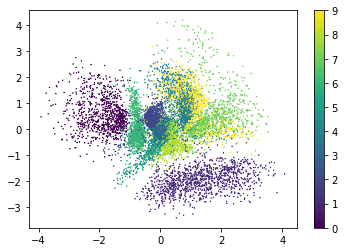

In [11]:
# Generate latent vectors of validation set
t_test = encoder.predict(x_test)[0]

# Plot latent vectors colored by the value of the digits on input images
plt.scatter(t_test[:, 0], t_test[:, 1], marker='x', s=0.2, c=y_test)
plt.colorbar();

The latent space is organized by structural similarity of the digits i.e. structurally similar digits have a smaller distance in latent space than structurally dissimilar digits. For example, digits 4 and 9 usually differ only by a horizontal bar or curve at the top of the image.

We can also generate new images by sampling from latent space and display a 2-dimensional manifold of digits. In the following figure, samples are drawn from the 90% confidence interval of the Gaussian prior with sampling density proportial to probability density. Visualization code was taken from [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb). One can clearly see the co-location of digits 4 and 9 in the bottom-right region of the image.

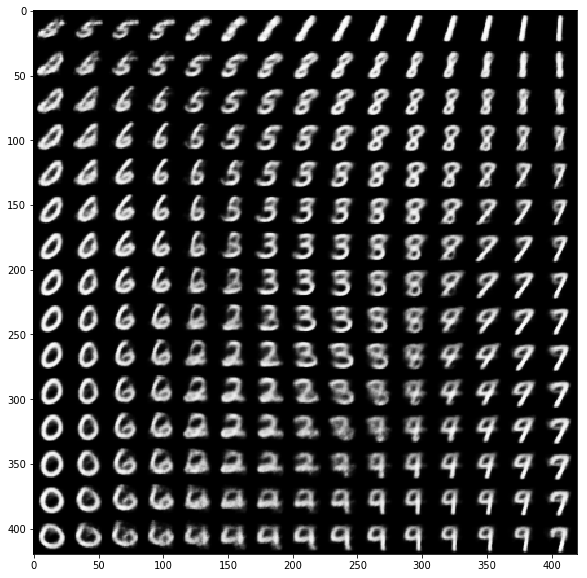

In [14]:
from scipy.stats import norm

# Number of samples per dimension
n = 15  

# Sample within 90% confidence interval of the Gaussian prior
# with sampling density proportional to probability density
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        t_sample = np.array([[xi, yi]])
        t_sample = np.tile(t_sample, batch_size).reshape(batch_size, 2)
        t_decoded = decoder.predict(t_sample, batch_size=batch_size)
        digit = t_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r');

## References

\[1\] Dimitris G. Tzikass, Aristidis et. al. [The Variational Approximation for Bayesian Inference](http://www.cs.uoi.gr/~arly/papers/SPM08.pdf).  
\[2\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapters 11 and 21.  
\[3\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](http://www.springer.com/de/book/9780387310732), Chapters 9 and 10.  
\[4\] Diederik P Kingma, Max Welling [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).  
\[5\] Gómez-Bombarelli et. al. [Automatic chemical design using a data-driven continuous representation of molecules](https://arxiv.org/abs/1610.02415).  
\[6\] François Chollet. [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).  